
# Autoencoders: A Deep Dive

<div align="center">
  <img src="../assets/img/ae_1.png" width="800px"> </div>


### Introduction

Autoencoders are a type of artificial neural network used for unsupervised learning. They are designed to learn efficient data codings by projecting the input data into a lower-dimensional latent space and then reconstructing the original data from this representation. This process forces the autoencoder to capture the most important features of the input data.

### Architecture of an Autoencoder

A typical autoencoder consists of two main components:

* **Encoder:** This part of the network maps the input data to a latent space representation.
* **Decoder:** This part reconstructs the original data from the latent space representation.

The goal of training is to minimize the reconstruction error between the input and the reconstructed output.

### Types of Autoencoders

There are several variations of autoencoders:

* **Undercomplete Autoencoders:** These have a smaller latent space than the input space, forcing the network to learn a compressed representation of the data.
* **Denoising Autoencoders:** These are trained on corrupted input data, learning to reconstruct the original clean data.
* **Variational Autoencoders (VAEs):** These introduce probabilistic elements into the encoding process, allowing for generating new data samples.
* **Convolutional Autoencoders (CAEs):** These use convolutional layers, making them suitable for image data.

### Applications of Autoencoders

Autoencoders have a wide range of applications:

* **Dimensionality Reduction:** By projecting data into a lower-dimensional space, autoencoders can be used for visualization and feature extraction.
* **Image Denoising:** Denoising autoencoders can effectively remove noise from images.
* **Anomaly Detection:** Autoencoders can be used to identify unusual data points by measuring reconstruction errors.
* **Image Generation:** VAEs can generate new, realistic images based on the learned latent space distribution.
* **Data Compression:** Undercomplete autoencoders can be used for data compression.

### PyTorch Implementation

Let's implement a basic autoencoder using PyTorch for image compression:

In [39]:
import os
import torch

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from IPython.display import clear_output


os.chdir("../")

from src import data_loader
from src import ae

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Fashion MNIST Dataset

**Breakdown:**

1. **Import necessary libraries:**
   * `torchvision.transforms`: For image transformations.
   * `torchvision.datasets`: For loading the MNIST dataset.

2. **Define image transformations:**
   * `transforms.ToTensor()`: Converts PIL images to PyTorch tensors.
   * `transforms.Normalize()`: Normalizes tensor images with mean and standard deviation of 0.5.

3. **Load training data:**
   * `torchvision.datasets.FashionMNIST`: Loads the Fashion MNIST training dataset.
   * `root`: Specifies the data directory.
   * `train`: Set to `True` for training data.
   * `download`: Downloads the dataset if not present.
   * `transform`: Applies the defined transformations to the images.

4. **Load testing data:**
   * Similar to loading training data, but with `train=False` to load the test set.

In [ ]:
batch_size = 32

# This gives us the loader object which is iterable and also has batches of data
train_loader = data_loader.load_mnist_data()

clear_output()

Let's explore a little about the size of data and also what is included in it.

In [8]:
for i, data_ in enumerate(train_loader):
    print(i, data_[0].shape)
    if i==10:
        break

0 torch.Size([32, 1, 28, 28])
1 torch.Size([32, 1, 28, 28])
2 torch.Size([32, 1, 28, 28])
3 torch.Size([32, 1, 28, 28])
4 torch.Size([32, 1, 28, 28])
5 torch.Size([32, 1, 28, 28])
6 torch.Size([32, 1, 28, 28])
7 torch.Size([32, 1, 28, 28])
8 torch.Size([32, 1, 28, 28])
9 torch.Size([32, 1, 28, 28])
10 torch.Size([32, 1, 28, 28])


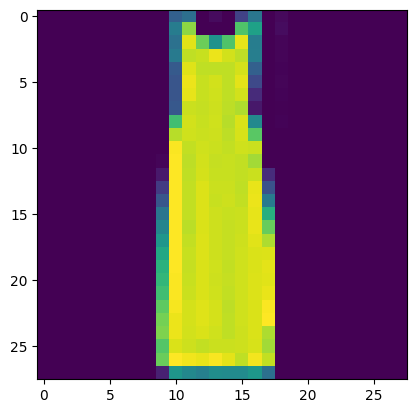

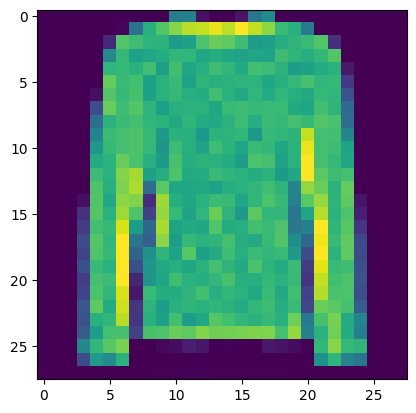

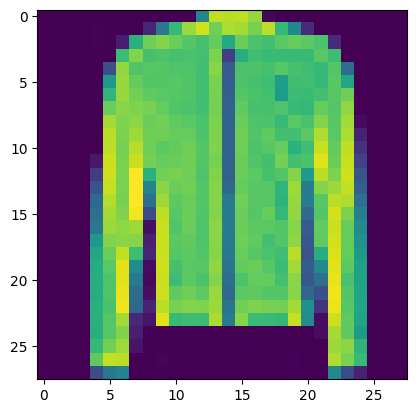

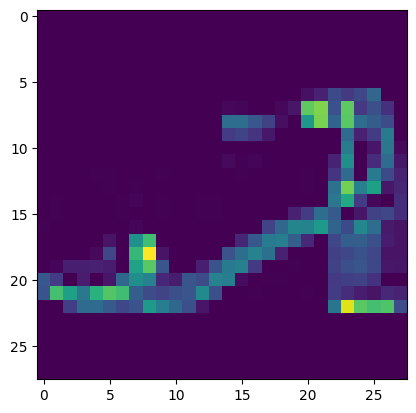

In [9]:
for i, data_ in enumerate(train_loader):
    plt.imshow(data_[0][i, :, :].view(28, 28))
    plt.show()
    if i==3:
        break

# Autoencoder Definition



# Define Model

Here we define our model which us based on Autoencoder class and use the optimizer based on `Adam Optimizer`.

First, We start with a simple Model which only uses Linear layers with Leaky Relu activations.

<div align="center">
       <img src="../assets/img/ae_2.png" width="800px"> </div>

In [14]:
class AutoencoderLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_en_1 = nn.Linear(in_features=28*28, out_features=196)
        self.linear_en_2 = nn.Linear(in_features=196, out_features=98)
        self.linear_de_1 = nn.Linear(in_features=98, out_features=196)
        self.linear_de_2 = nn.Linear(in_features=196, out_features=28*28)

    def forward(self, x):
        encode_1 = F.leaky_relu(self.linear_en_1(x))
        encode_2 = F.leaky_relu(self.linear_en_2(encode_1))
        decode_1 = F.leaky_relu(self.linear_de_1(encode_2))
        decode_2 = F.sigmoid(self.linear_de_2(decode_1))
        return decode_2

In [15]:
model_aal, optimizer, loss_fn = ae.make_model(AutoencoderLinear)

Is our model even working???

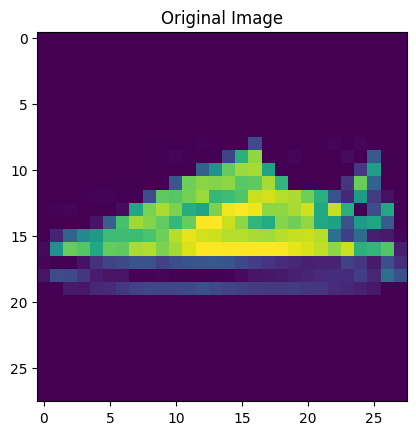

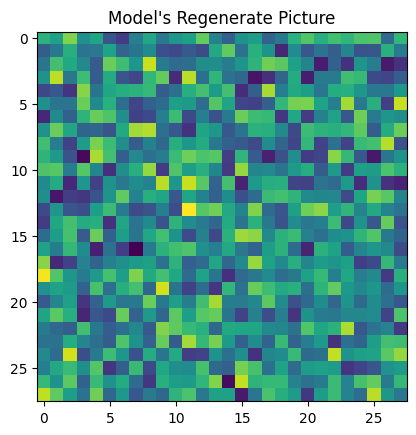

In [17]:
ae.test_model(train_loader, model_aal)

So we are just getting noise, Let's see what happens after a brief training.

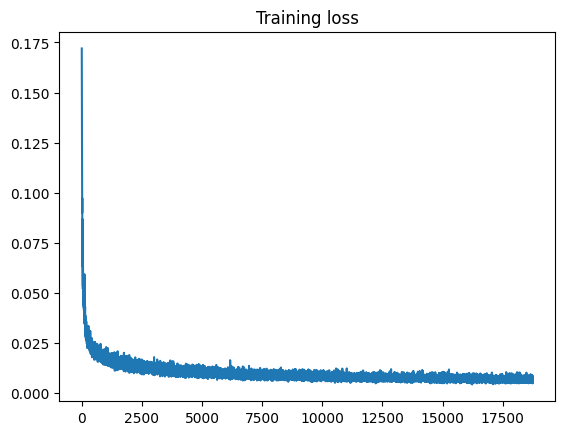

In [19]:
model_aal = ae.train_model(model_aal, optimizer, loss_fn, train_loader, batch_size, epoch_num=10)

Let's test that how much our model has learned to implicate the exact input by seeing the real images

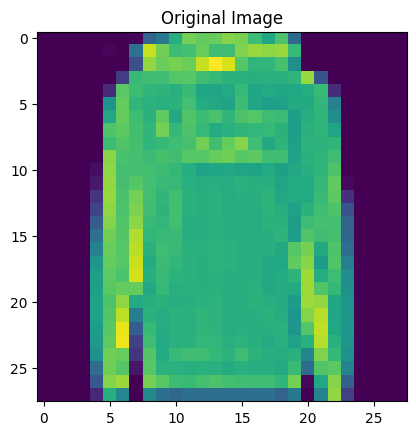

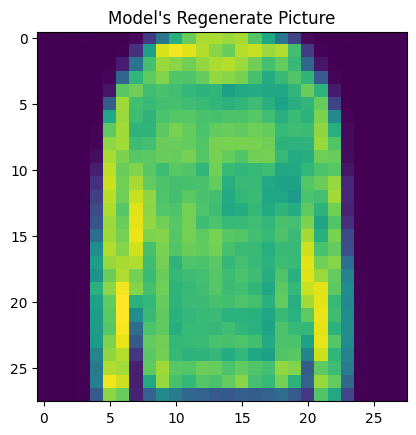

In [20]:
ae.test_model(train_loader, model_aal)

We can See that After 1 eposh of training our model is learning the general shape of the given input. so we are on the right track.

Let's make the linear model a bit dynamic. We add two linear layers which we could adjust the size of compression.

In [21]:
class AutoencoderLinearA(nn.Module):
    def __init__(self, compress_nodes):
        super().__init__()
        self.linear_en_1 = nn.Linear(in_features=28*28, out_features=196)
        self.linear_en_2 = nn.Linear(in_features=196, out_features=98)
        self.linear_de_1 = nn.Linear(in_features=98, out_features=196)
        self.linear_de_2 = nn.Linear(in_features=196, out_features=28*28)
        self.linear_en_c = nn.Linear(in_features=98, out_features=compress_nodes)
        self.linear_de_c = nn.Linear(in_features=compress_nodes, out_features=98)

    def forward(self, x):
        encode_1 = F.leaky_relu(self.linear_en_1(x))
        encode_2 = F.leaky_relu(self.linear_en_2(encode_1))
        encode_c = self.linear_en_c(encode_2)
        decode_c = self.linear_de_c(encode_c)
        decode_1 = F.leaky_relu(self.linear_de_1(decode_c))
        decode_2 = F.sigmoid(self.linear_de_2(decode_1))
        return decode_2

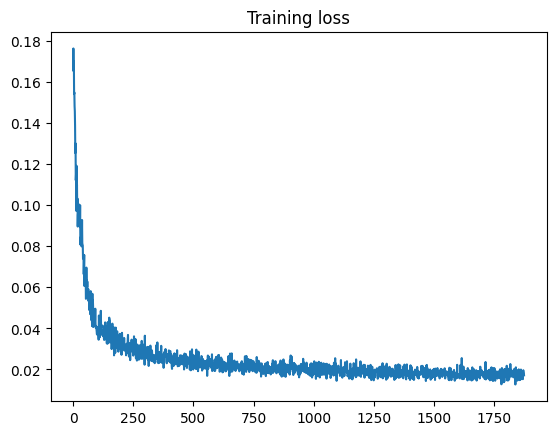

In [22]:
model_aala, optimizer, loss_fn = ae.make_model(AutoencoderLinearA, compress_=10)
model_aala = ae.train_model(model_aala, optimizer, loss_fn, train_loader, batch_size, epoch_num=1)

With a compression level which we compress all the 784 pixels to 10 nodes and then rescale them we still learning the general shape of the item after 1 epoch.

We might get better results if we try and use higher epochs, These results are just for 1 epoch.

Although we can see that when we decrease the compression nodes we are loosing some data which increases the training error, as you can compare the charts before.

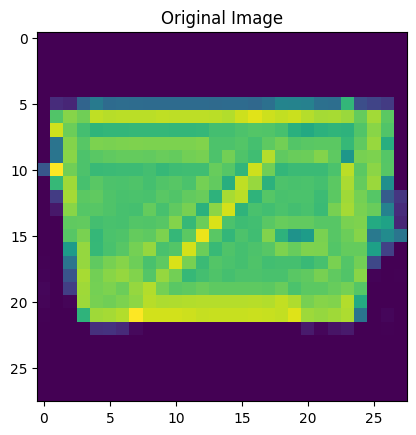

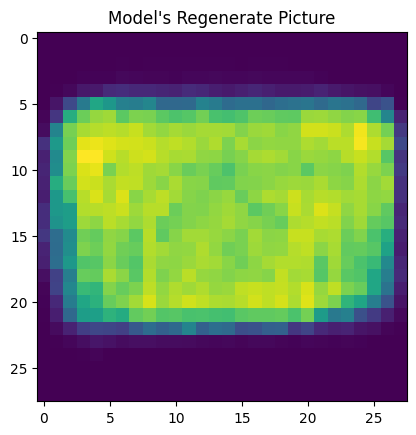

In [23]:
ae.test_model(model_=model_aala, loader_obj=train_loader)

# Autoencoder with CNN

<div align="center">
    <img src="../assets/img/ae_3.png" width="800px"> </div>
(The image is just for showing the structure of)
This Python code defines a convolutional autoencoder class using PyTorch. The autoencoder consists of an encoder and a decoder network.

**Encoder:**
* Takes a 1-Channel image as input.
* Applies a series of convolutional layers with LeakyReLU activations to extract features.
* Uses a flattening layer to convert the feature maps into a linear vector.
* Finally, projects the vector into a latent space representation.

**Decoder:**
* Takes the latent space representation as input.
* Projects it back to the original feature map size using a linear layer and unflattening.
* Applies a series of transposed convolutional layers with LeakyReLU activations to reconstruct the image.
* Uses a sigmoid activation function to output the reconstructed image with pixel values between 0 and 1.

**Forward Pass:**
* Encodes the input image using the encoder.
* Decodes the encoded representation using the decoder.
* Returns the reconstructed image.

In [24]:
# Build the Autoencoder with CNN using the sequential method from pytorch
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=(1,1)),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(5,5), stride=(1,1)),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2,2), stride=(2,2)),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(in_features=128*10*10, out_features=144)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=144, out_features=128*10*10),
            nn.Unflatten(1, (128, 10, 10)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(2,2), stride=(2,2)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=(5,5), stride=(1,1)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(5,5), stride=(1,1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

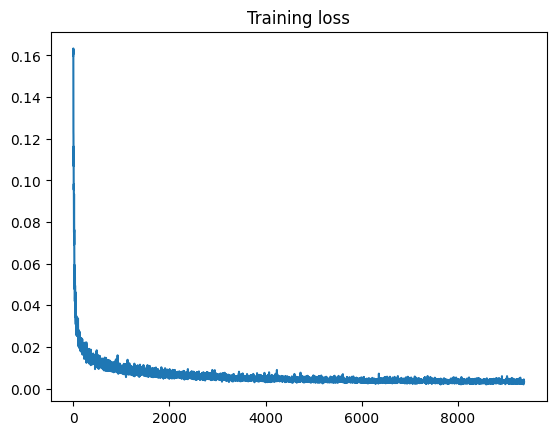

In [29]:
model_cnn, optimizer, loss_fn = ae.make_model(AutoencoderCNN)
model_cnn = ae.train_model(model_cnn, optimizer, loss_fn, train_loader, batch_size, epoch_num=5, model_linear=False)

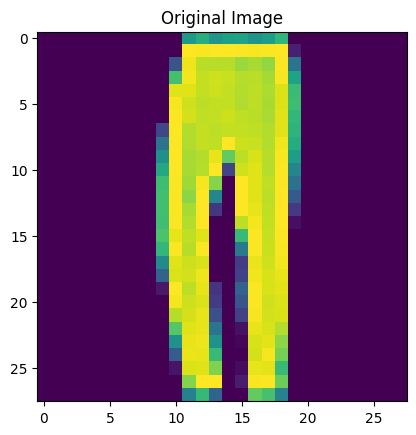

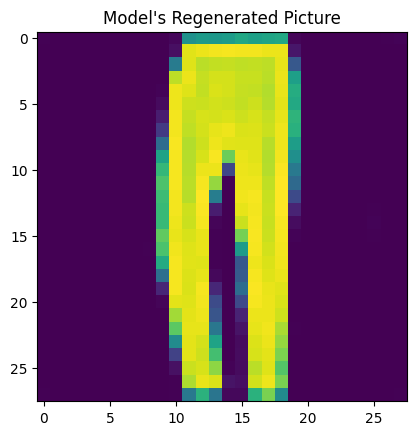

In [31]:
ae.test_model(train_loader, model_cnn, linear=False)

Looks like we have achieved a better result using a CNN Autoencoder with just only 1 epoch but a longer training time. (8 minutes instead of 30 seconds trainingtime)

Let's take a look at the output of the encoder which compresses the data and convert it to a picture to see if there is anything meaningful in there.

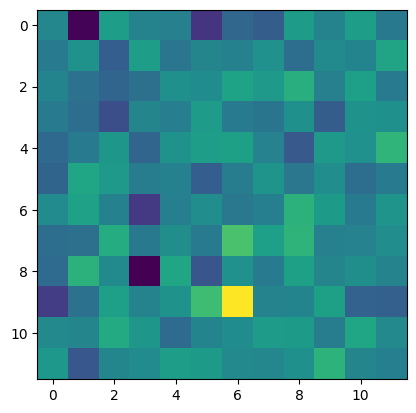

In [32]:
batch_iter = iter(train_loader)
batch_images = next(batch_iter)
tmp_image = batch_images[0][0, 0, :, :]
enc_output = model_cnn.encoder(tmp_image.reshape(1, 1, 28, 28))

# We have 144 Nodes so we can derive a 12*12 picture from it.
plt.imshow(enc_output.detach().numpy().reshape(12, 12))
plt.show()

## Noise

Let's introduce some noise to the picture and see how our model is working to regenrate the output withouht noise.

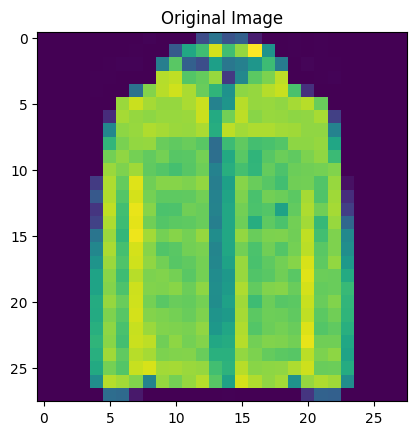

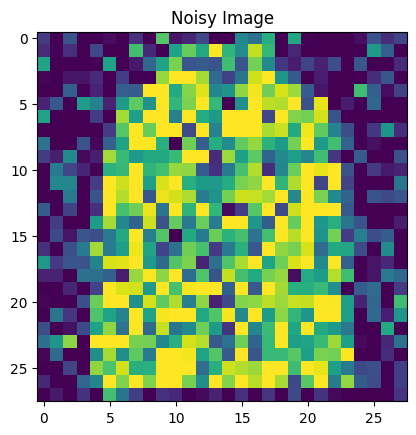

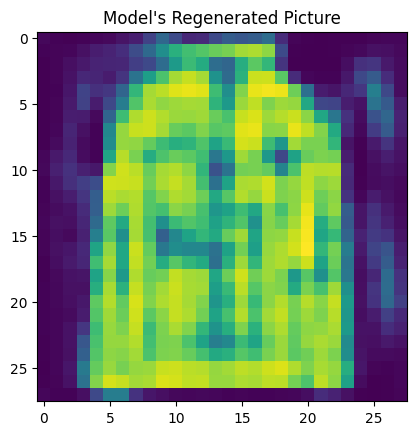

In [85]:
ae.noisy_test(train_loader, model_cnn, linear=False, noise_intensity=0.3)